[*********************100%%**********************]  1 of 1 completed
c:\Users\ivoto\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\ivoto\AppData\Local\Temp\ipykernel_9828\1297206111.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context = torch.tensor(train_df["Close"])


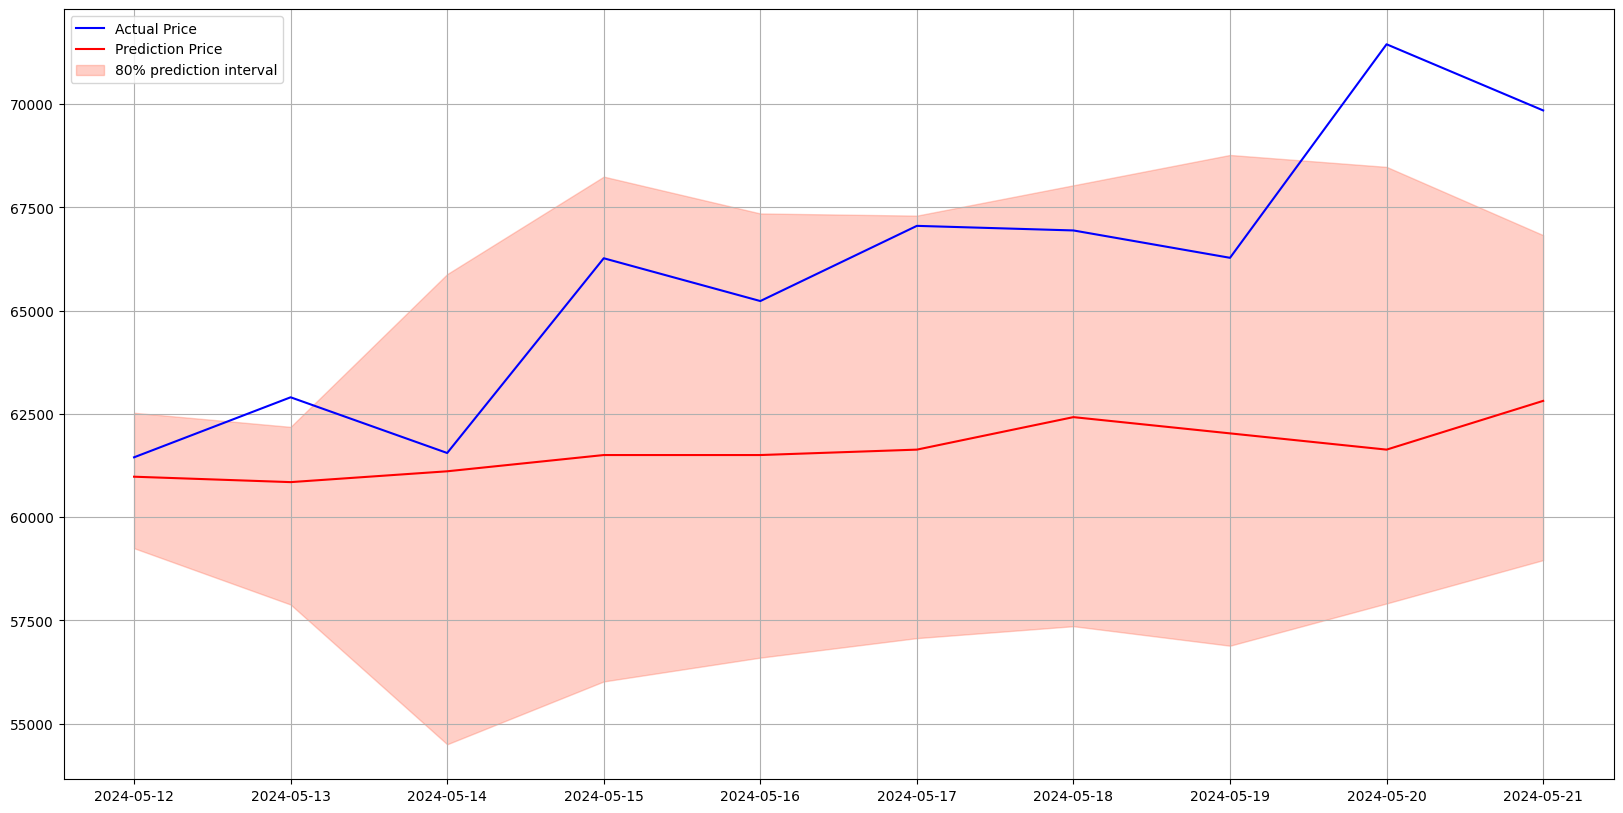

In [20]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from chronos import ChronosPipeline
import yfinance as yf

token = "BTC-USD"
token = yf.download(token)
token.to_csv("BTC-USD.csv")


df = pd.read_csv("BTC-USD.csv", index_col="Date", parse_dates=True)
df.dropna(inplace=True)

dias = 10

train_size = int(len(df) - dias)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

#Hacemos las predicciones
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.float32,
)

prediction_length = dias
context = torch.tensor(train_df["Close"])
forecast = pipeline.predict(context, prediction_length, num_samples=20)

low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(20,10))
plt.plot(test_df.index, test_df["Close"], label="Actual Price",color="blue")
plt.plot(test_df.index, median, color="red", label="Prediction Price")
plt.fill_between(test_df.index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
list_num_samples = [5,10,15,20,50,100,150,200]

def forecast_with_samples(
        pipeline,
        context,
        prediction_length,
        list_num_samples,
        test_df,
        ):
    for num_sample in list_num_samples:
        forecast = pipeline.predict(context, prediction_length, num_sample)
        low, median, high = np.quantile(forecast[0].numpy(), [0.1,0.5,0.9], axis=0)
        mae = mean_absolute_error(test_df["Close"], median)
        mse = mean_squared_error(test_df["Close"], median)
        print(f"This is sample {num_sample}")
        print(f"MAE={mae}")
        print(f"MSE={mse}")

forecast_values = forecast_with_samples(pipeline,context, prediction_length, list_num_samples, test_df)

This is sample 5
MAE=5521.353958939266
MSE=43151082.03670092
This is sample 10
MAE=2977.2957670290284
MSE=12554856.358753443
This is sample 15
MAE=3990.2426409761015
MSE=22035567.15670288
This is sample 20
MAE=4501.681961433933
MSE=29143623.76998558
This is sample 50
MAE=4708.304363345521
MSE=31945489.219368696
This is sample 100
MAE=3960.8257047233797
MSE=22711508.775592644


OutOfMemoryError: CUDA out of memory. Tried to allocate 302.00 MiB. GPU 0 has a total capacity of 11.00 GiB of which 0 bytes is free. Of the allocated memory 17.34 GiB is allocated by PyTorch, and 131.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [23]:
from pathlib import Path
from typing import List, Optional, Union
import pandas as pd
import numpy as np
from gluonts.dataset.arrow import ArrowWriter




def convert_to_arrow(
    path: Union[str, Path],
    time_series: Union[List[np.ndarray], np.ndarray],
    start_times: Optional[Union[List[np.datetime64], np.ndarray]] = None,
    compression: str = "lz4",
):
    if start_times is None:
        # Set an arbitrary start time
        start_times = [np.datetime64("2000-01-01 00:00", "s")] * len(time_series)

    assert len(time_series) == len(start_times)

    dataset = [
        {"start": start, "target": ts} for ts, start in zip(time_series, start_times)
    ]
    ArrowWriter(compression=compression).write_to_file(
        dataset,
        path=path,
    )


if __name__ == "__main__":
    df = pd.read_csv("BTC-USD.csv", index_col="Date", parse_dates=True)
    time_series = [df['Close'].values]
    start_times = [df.index.values[0]]
    
    convert_to_arrow("./bitcoin_prices.arrow", time_series=time_series, start_times=start_times)


In [12]:
import yfinance as yf

tick = "BTC-USD"

token = yf.download(tick)

print(token.type)

[*********************100%%**********************]  1 of 1 completed


AttributeError: 'DataFrame' object has no attribute 'type'